Import modules

In [106]:
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F

base_path = "./../Dataset/cifake"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")


Loading datasets using ImageFolder and DataLoaders

In [107]:
# convert to tensors and normalise pixel values to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

In [108]:
val_ratio = 0.2
val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(f"Validation Dataset Shape: {val_dataset.__len__()}")
print(f"Training Dataset Shape: {train_dataset.__len__()}")

Validation Dataset Shape: 20000
Training Dataset Shape: 80000


In [109]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # (batch, channel, height, width)
print(f"Batch label shape: {labels.shape}")  # (batch,)
print(f"Labels: {labels}")

Batch image shape: torch.Size([32, 3, 32, 32])
Batch label shape: torch.Size([32])
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1])


showing image samples

In [110]:
def show_real_vs_fake_images(data_loader, class_names):
    """
    Displays 2 real CIFAR-10 images (label 1) and 2 AI-generated images (label 0) side by side.

    Args:
        data_loader: DataLoader object containing the images and labels.
        class_names: List of class names corresponding to the dataset.
    """
    real_images = []
    fake_images = []

    for features, labels in data_loader:
        for i in range(len(labels)):
            if len(real_images) < 2 and labels[i].item() == 1:  # real images
                real_images.append(features[i])
            elif len(fake_images) < 2 and labels[i].item() == 0:  # fake images
                fake_images.append(features[i])
            if len(real_images) == 2 and len(fake_images) == 2:
                break
        if len(real_images) == 4 and len(fake_images) == 4:
            break

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle("Top Row: Real CIFAR-10 | Bottom Row: AI-Generated", fontsize=14)

    for i, img in enumerate(real_images):
        img = img.permute(1, 2, 0)  # convert (C, H, W) to (H, W, C)
        img = img / 2 + 0.5  # pixel values from [-1, 1] to [0, 1]
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {class_names[1]}")
        axes[0, i].axis("off")

    for i, img in enumerate(fake_images):
        img = img.permute(1, 2, 0)
        img = img / 2 + 0.5  
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Label: {class_names[0]}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [111]:
# class_names = ["FAKE (0)", "REAL (1)"]
# show_real_vs_fake_images(train_loader, class_names)

Creating model

In [112]:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super().__init__()
# 
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,
#                                padding=1)  # Input: (3, 32, 32) Output: (32, 32, 32)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,
#                                padding=1)  # Input: (32, 32, 32) Output: (64, 32, 32)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,
#                                padding=1)  # Input: (64, 32, 32) Output: (128, 32, 32)
# 
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2
# 
#         self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)  # flatten output from pool
#         self.fc2 = nn.Linear(in_features=512, out_features=1)
# 
#         self.dropout = nn.Dropout(p=0.2)
# 
#     def forward(self, x):
#         x = F.relu(self.conv1(x))  # Output: (32, 32, 32)
#         x = self.pool(F.relu(self.conv2(x)))  # Output: (64, 16, 16)
#         x = self.pool(F.relu(self.conv3(x)))  # Output: (128, 8, 8)
# 
#         x = x.view(-1, 128 * 8 * 8)  # flatten to (batch_size, 128 * 8 * 8)
# 
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x) 
#         x = self.fc2(x)  # no need for activation, BCELossWithLogits combines sigmoid
# 
#         return x

In [113]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,
                               padding=1)  # Input: (3, 32, 32) Output: (32, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,
                               padding=1)  # Input: (32, 32, 32) Output: (64, 32, 32)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,
                               padding=1)  # Input: (64, 32, 32) Output: (128, 32, 32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2

        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=512)  # flatten output from pool
        self.fc2 = nn.Linear(in_features=512, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (64, 8, 8)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (128, 4, 4)

        x = x.view(-1, 128 * 4 * 4)  # flatten to (batch_size, 128 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # no need for activation, BCELossWithLogits combines sigmoid
        x = self.fc3(x)

        return x

In [114]:
from torchsummary import summary

model = CNNModel()
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 512]       1,049,088
            Linear-8                  [-1, 120]          61,560
            Linear-9                    [-1, 1]             121
Total params: 1,204,017
Trainable params: 1,204,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.59
Estimated Total Size (MB): 5.16
---------------------------------------

Hyperparameters

In [115]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)
epochs = 20
lambda_L1 = 0
lambda_L2 = 0
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [120]:
def batch_train(inputs, labels):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)

    labels = labels.unsqueeze(1).float()

    # L1 penalty
    l1_regularization = 0
    if lambda_L1 > 0.0:
        for param in model.parameters():
            l1_regularization += torch.norm(param,1)
        
    l2_regularization = 0
    if lambda_L2 > 0.0:
        for param in model.parameters():
            l2_regularization += torch.norm(param,2)
    
    batch_loss = loss_fn(outputs, labels) + lambda_L1 * l1_regularization + lambda_L2 * l2_regularization

    # Backward pass
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

In [121]:
@torch.no_grad()
def batch_val(inputs, labels):
    model.eval()
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    labels = labels.unsqueeze(1).float()
    val_loss = loss_fn(outputs, labels)
    return val_loss.item()

In [122]:
def train_model():
    loss_hist = []
    val_loss_hist = []

    for epoch in range(epochs):
        batch_losses = []
        batch_val_losses = []
        
        for i, data in enumerate(iter(train_loader)):
            inputs, labels = data
            batch_loss = batch_train(inputs, labels)
            batch_losses.append(batch_loss) # track loss for every batch
            
        for i, data in enumerate(iter(val_loader)):
            inputs, labels = data
            val_loss = batch_val(inputs, labels)
            batch_val_losses.append(val_loss)

        one_epoch_loss = np.array(batch_losses).mean() # calculate loss for one epoch
        one_epoch_val_loss = np.array(batch_val_losses).mean()
        loss_hist.append(one_epoch_loss) # track loss for every epoch
        val_loss_hist.append(one_epoch_val_loss)

        scheduler.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, training loss: {one_epoch_loss:.4f}, validation loss: {one_epoch_val_loss:.4f}")

    return loss_hist, val_loss_hist

In [ ]:
loss_history, val_loss_history = train_model()

Saving model

In [90]:
torch.save(model.to('cpu').state_dict(), 'mymodel_task2_scheduler.pth')

Plotting loss

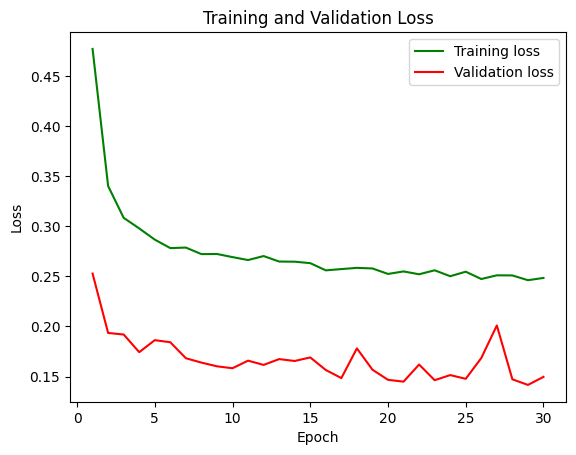

In [91]:
y_arr = np.arange(epochs)+1
plt.plot(y_arr, loss_history, 'g', label='Training loss')
plt.plot(y_arr, val_loss_history, 'r', label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()